In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from glob import glob
print("Total images:",len(glob("data/*/*.jpg")))

positive_images = glob("data/Positive/*.jpg")
negative_images = glob("data/Negative/*.jpg")
print("Number of positive images:", len(positive_images))
print("Number of negative images:", len(negative_images))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Total images: 40000
Number of positive images: 20000
Number of negative images: 20000


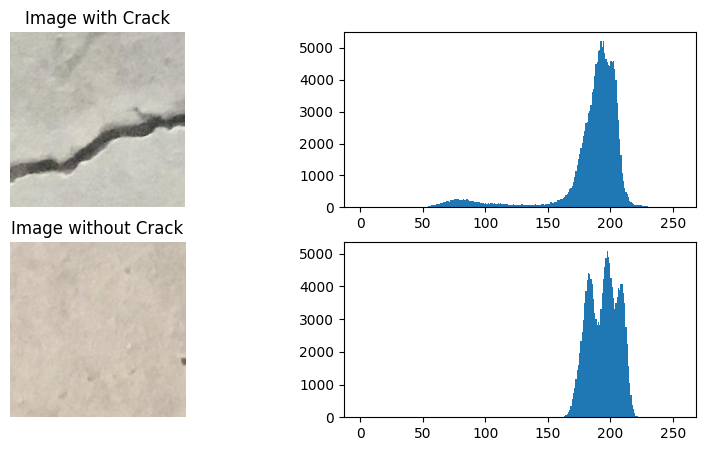

In [3]:
# Plot histogram between positive image and negative image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

positive_image = cv2.imread(random.choice(positive_images))
negative_image = cv2.imread(random.choice(negative_images))
# plot histogram
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax[0][0].imshow(cv2.cvtColor(positive_image, cv2.COLOR_BGR2RGB))
ax[0][0].set_title("Image with Crack")
ax[0][0].axis("off")
ax[0][1].hist(positive_image.ravel(), bins=256, range=[0, 256])

ax[1][0].imshow(cv2.cvtColor(negative_image, cv2.COLOR_BGR2RGB))
ax[1][0].set_title("Image without Crack")
ax[1][0].axis("off")
ax[1][1].hist(negative_image.ravel(), bins=256, range=[0, 256])
plt.show()

In [4]:
positive_image.shape

(227, 227, 3)

In [50]:
# custom torch Dataset that takes in the image paths
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple

class SurfaceCrackDataset(Dataset):
    def __init__(self, image_paths: List[Tuple[str, int]], transform=None):
        self.image_paths = list(map(lambda x: x[0], image_paths))
        self.labels = list(map(lambda x: x[1], image_paths))
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path, label = self.image_paths[idx], self.labels[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label
    
def train_test_split(positive_images, negative_images, val_size=0.1, test_size=0.1, random_state=42):
    np.random.seed(random_state)
    np.random.shuffle(positive_images)
    np.random.shuffle(negative_images)
    
    # make sure the dataset is balanced in train, val and test
    pos_train_size = int(len(positive_images) * (1 - val_size - test_size))
    pos_val_size = int(len(positive_images) * val_size)
    pos_test_size = int(len(positive_images) * test_size)

    neg_train_size = int(len(negative_images) * (1 - val_size - test_size))
    neg_val_size = int(len(negative_images) * val_size)
    neg_test_size = int(len(negative_images) * test_size)

    pos_train = positive_images[:pos_train_size]
    pos_val = positive_images[pos_train_size:pos_train_size+pos_val_size]
    pos_test = positive_images[pos_train_size+pos_val_size:]

    neg_train = negative_images[:neg_train_size]
    neg_val = negative_images[neg_train_size:neg_train_size+neg_val_size]
    neg_test = negative_images[neg_train_size+neg_val_size:]

    # handle labels
    def label_images(images, label):
        return [(image, label) for image in images]
    
    pos_train, pos_val, pos_test = label_images(pos_train, 1), label_images(pos_val, 1), label_images(pos_test, 1)
    neg_train, neg_val, neg_test = label_images(neg_train, 0), label_images(neg_val, 0), label_images(neg_test, 0)
    
    return pos_train + neg_train, pos_val + neg_val, pos_test + neg_test


def create_datasets(train_images, val_images, test_images, train_transform, val_transform):
    train_dataset = SurfaceCrackDataset(train_images, transform=train_transform)
    val_dataset = SurfaceCrackDataset(val_images, transform=val_transform)
    test_dataset = SurfaceCrackDataset(test_images, transform=val_transform)
    
    return train_dataset, val_dataset, test_dataset

from torchvision import transforms
from PIL import Image

train_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
])

train_images, val_images, test_images = train_test_split(positive_images, negative_images)
train_dataset, val_dataset, test_dataset = create_datasets(train_images, val_images, test_images, train_transform, val_transform)
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 32000
Validation dataset size: 4000
Test dataset size: 4000


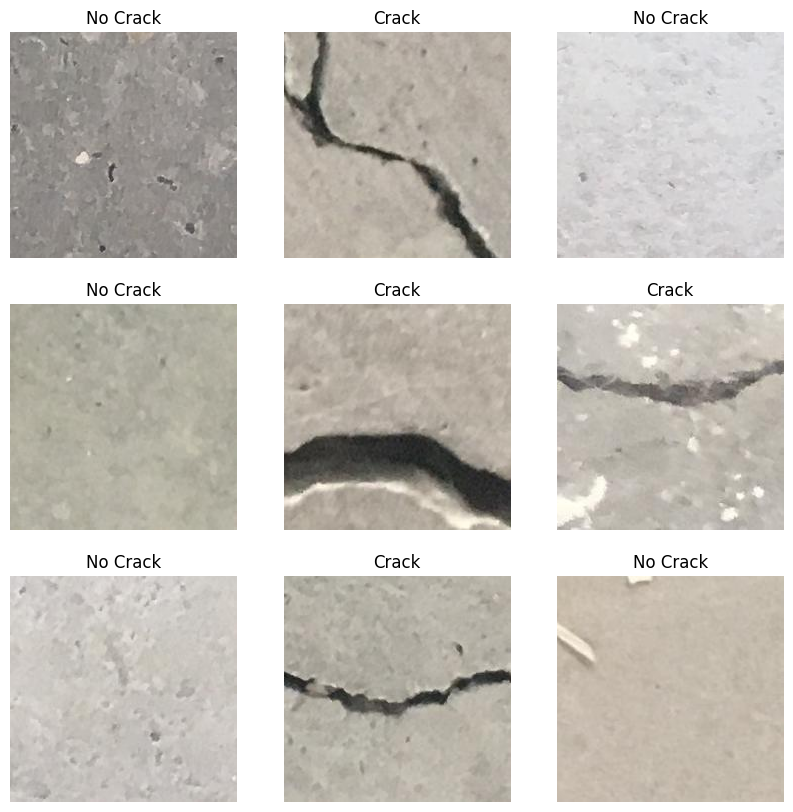

In [14]:
def visualize_images_with_label(dataset, grid=(3,3)):
    fig, ax = plt.subplots(grid[0], grid[1], figsize=(10, 10))
    for i in range(grid[0]):
        for j in range(grid[1]):
            image, label = random.choice(dataset)
            ax[i][j].imshow(image.permute(1, 2, 0))
            ax[i][j].set_title("Crack" if label == 1 else "No Crack")
            ax[i][j].axis("off")
    plt.show()

visualize_images_with_label(val_dataset, grid=(3,3))

In [17]:
# print the number of positive and negative images in the train, val and test dataset
from tqdm import tqdm
def print_dataset_stats(dataset, name):
    num_pos = sum(dataset.labels)
    num_neg = len(dataset) - num_pos
    print(f"{name} dataset")
    print(f"Number of positive images: {num_pos}")
    print(f"Number of negative images: {num_neg}")
    print("-" * 20)

print_dataset_stats(train_dataset, "Train")
print_dataset_stats(val_dataset, "Validation")
print_dataset_stats(test_dataset, "Test")

Train dataset
Number of positive images: 16000
Number of negative images: 16000
--------------------
Validation dataset
Number of positive images: 2000
Number of negative images: 2000
--------------------
Test dataset
Number of positive images: 2000
Number of negative images: 2000
--------------------


In [19]:
# create a dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [20]:
# create a simple CNN model
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [22]:
import torchsummary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
torchsummary.summary(model, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 227, 227]             896
            Conv2d-2         [-1, 64, 113, 113]          18,496
            Conv2d-3          [-1, 128, 56, 56]          73,856
            Linear-4                  [-1, 128]      12,845,184
            Linear-5                    [-1, 1]             129
Total params: 12,938,561
Trainable params: 12,938,561
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.59
Forward/backward pass size (MB): 21.88
Params size (MB): 49.36
Estimated Total Size (MB): 71.83
----------------------------------------------------------------


In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
lr_cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

def accuracy(outputs, labels, threshold=0.5):
    preds = torch.sigmoid(outputs) > threshold
    return (preds == labels).float().mean()

def train_step(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    # make tqdm to display a progress bar and append the loss
    pbar = tqdm(train_loader, total=len(train_loader), desc="Training")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_postfix({'Train Loss': loss.item(), 'Train Acc': accuracy(outputs, labels).item()})
    return running_loss / len(train_loader)

def val_step(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        pbar = tqdm(val_loader, total=len(val_loader), desc="Validation")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            running_loss += loss.item()
            pbar.set_postfix({'Train Loss': loss.item(), 'Train Acc': accuracy(outputs, labels).item()})
    return running_loss / len(val_loader)

def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}/{epochs}")
        train_loss = train_step(model, train_loader, criterion, optimizer, device)
        val_loss = val_step(model, val_loader, criterion, device)
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

train(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)

Epoch: 1/10


Val Loss: 0.0596, Val Acc: 1.0000: 100%|██████████| 125/125 [02:27<00:00,  1.18s/it]


Train Loss: 0.1033, Val Loss: 0.0469
Epoch: 2/10


Train Loss: 0.0192, Train Acc: 0.5020:   0%|          | 1/1000 [00:06<1:52:23,  6.75s/it]


KeyboardInterrupt: 

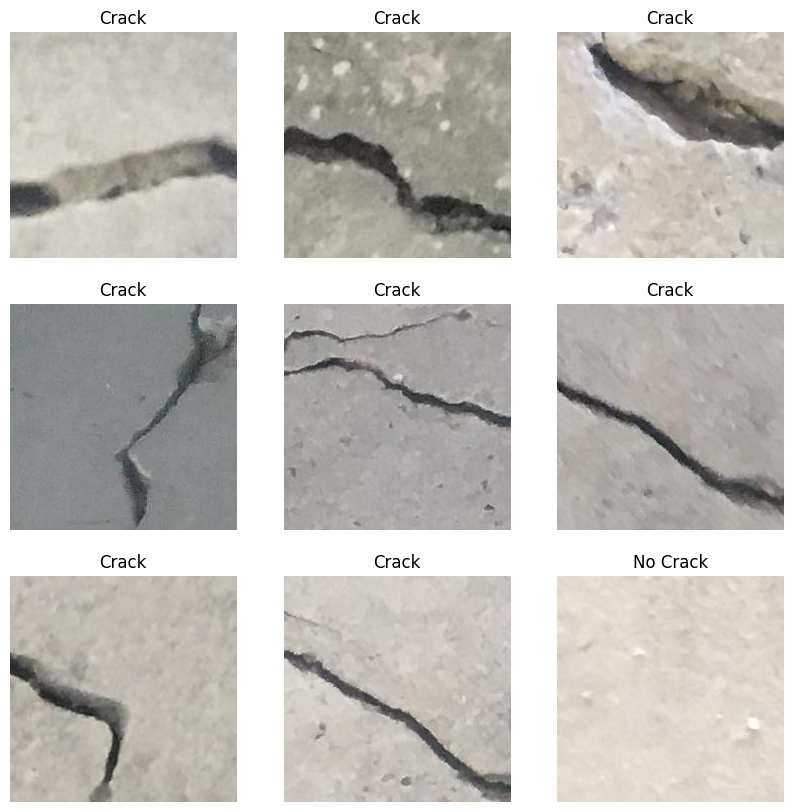

In [103]:
def visualize_model(model, dataset, device, grid=(3,3), n_dims=3):
    model.eval()
    fig, ax = plt.subplots(grid[0], grid[1], figsize=(10, 10))
    for i in range(grid[0]):
        for j in range(grid[1]):
            image, label = random.choice(dataset)
            if n_dims == 3: image = image.unsqueeze(0)
            elif n_dims == 2: image = image.unsqueeze(0).unsqueeze(0)
            image = image.to(device)
            output = torch.sigmoid(model(image)).item()
            ax[i][j].imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
            ax[i][j].set_title("Crack" if output > 0.5 else "No Crack")
            ax[i][j].axis("off")
    plt.show()

visualize_model(model, val_dataset, device, grid=(3,3))

In [26]:
# save the model
torch.save(model.state_dict(), "cnn.pth")

## Using Segmentation Method

In [37]:
# take 100 images from the positive images and calculate the ravel for each image
images = []
for i in range(100):
    image = cv2.imread(random.choice(positive_images))
    images.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).ravel())
images = np.array(images)

images.shape

(100, 51529)

In [38]:
average_image = np.mean(images, axis=0)
average_image.shape

(51529,)

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

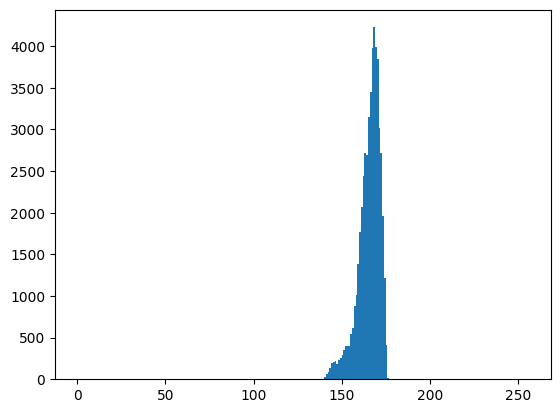

In [39]:
# histogram of the average image
plt.hist(average_image, bins=256, range=[0, 256])

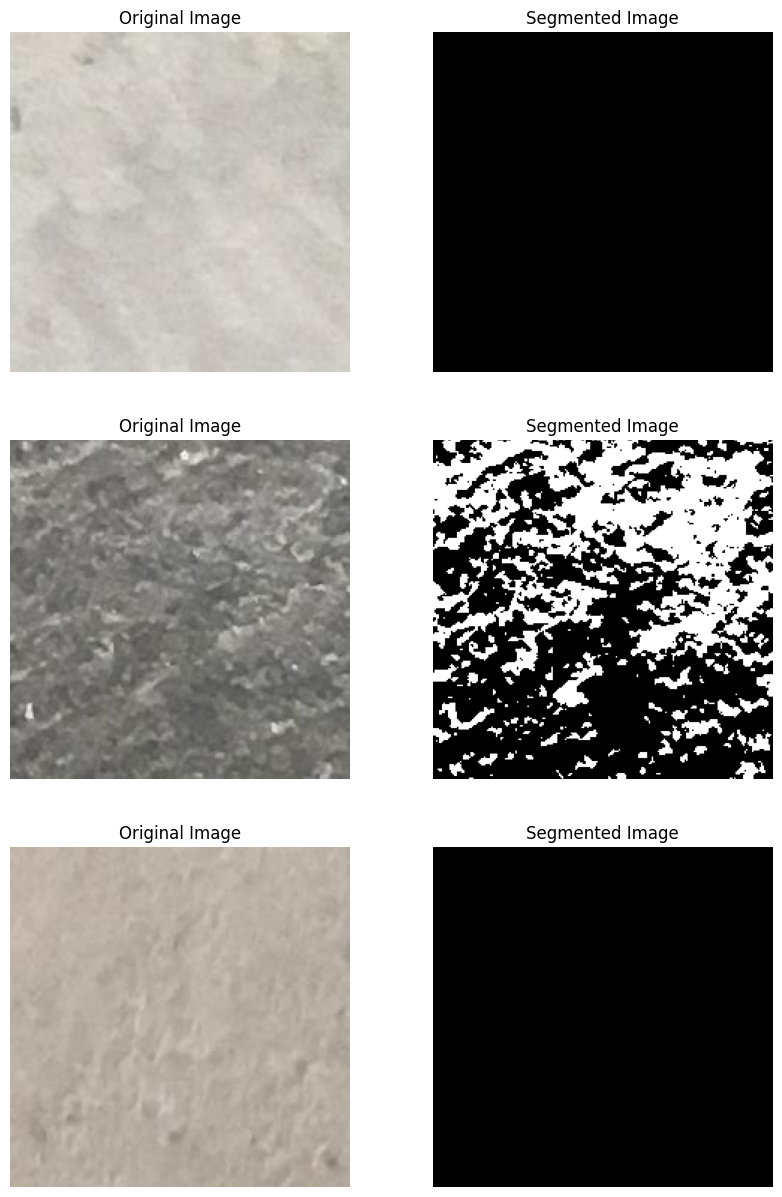

In [47]:
# set the segmentation threshold to 150

def segment_image(image, threshold=125):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return binary_image

# plot 3 segmented images in 3 rows alongside the original image
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
for i in range(3):
    image = cv2.imread(random.choice(negative_images))
    binary_image = segment_image(image)
    ax[i][0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i][0].set_title("Original Image")
    ax[i][0].axis("off")
    ax[i][1].imshow(binary_image, cmap="gray")
    ax[i][1].set_title("Segmented Image")
    ax[i][1].axis("off")

plt.show()

In [89]:
# create a custom pytorch transform to segment the image based on the threshold

class SegmentImage:
    def __init__(self, threshold=125):
        self.threshold = threshold
        
    def __call__(self, image):
        image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
        _, binary_image = cv2.threshold(image, self.threshold, 255, cv2.THRESH_BINARY)
        return Image.fromarray(binary_image)
    
    
segment_train_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(),
    SegmentImage(),
    transforms.ToTensor(),
])

segment_val_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    SegmentImage(),
    transforms.ToTensor(),
])

segment_train_dataset, segment_val_dataset, segment_test_dataset = create_datasets(train_images,
                                                                                   val_images,
                                                                                   test_images,
                                                                                   segment_train_transform,
                                                                                   segment_val_transform)

print("Train dataset size:", len(segment_train_dataset))
print("Validation dataset size:", len(segment_val_dataset))
print("Test dataset size:", len(segment_test_dataset))

Train dataset size: 32000
Validation dataset size: 4000
Test dataset size: 4000


In [90]:
# create a dataloader
segment_train_loader = DataLoader(segment_train_dataset, batch_size=32, shuffle=True)
segment_val_loader = DataLoader(segment_val_dataset, batch_size=32, shuffle=False)
segment_test_loader = DataLoader(segment_test_dataset, batch_size=32, shuffle=False)

In [91]:
# open a random image from the segmented dataset
image, label = random.choice(segment_train_dataset)
image.type()

'torch.FloatTensor'

In [96]:
# make the same CNN model as before, but since the input is 1 layer, we need to change the input channels to 1
# also, this CNN should accept integer inputs
import torch
import torchao

class SegmentedCNN(nn.Module):
    def __init__(self):
        super(SegmentedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
segment_model = SegmentedCNN().to(device)

torchsummary.summary(segment_model, (1, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 227, 227]             320
            Conv2d-2         [-1, 64, 113, 113]          18,496
            Conv2d-3          [-1, 128, 56, 56]          73,856
            Linear-4                  [-1, 128]      12,845,184
            Linear-5                    [-1, 1]             129
Total params: 12,937,985
Trainable params: 12,937,985
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.20
Forward/backward pass size (MB): 21.88
Params size (MB): 49.35
Estimated Total Size (MB): 71.43
----------------------------------------------------------------


In [97]:
segmented_optimizer = torch.optim.Adam(segment_model.parameters(), lr=0.001)
segmented_criterion = nn.BCEWithLogitsLoss()

train(segment_model, segment_train_loader, segment_val_loader, segmented_criterion, segmented_optimizer, device, epochs=1)

Epoch: 1/1


  0%|          | 0/1000 [00:00<?, ?it/s]

Val Loss: 0.1607, Val Acc: 0.9375: 100%|██████████| 125/125 [02:18<00:00,  1.11s/it]

Train Loss: 0.1093, Val Loss: 0.0735


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1, 1, 227, 227]

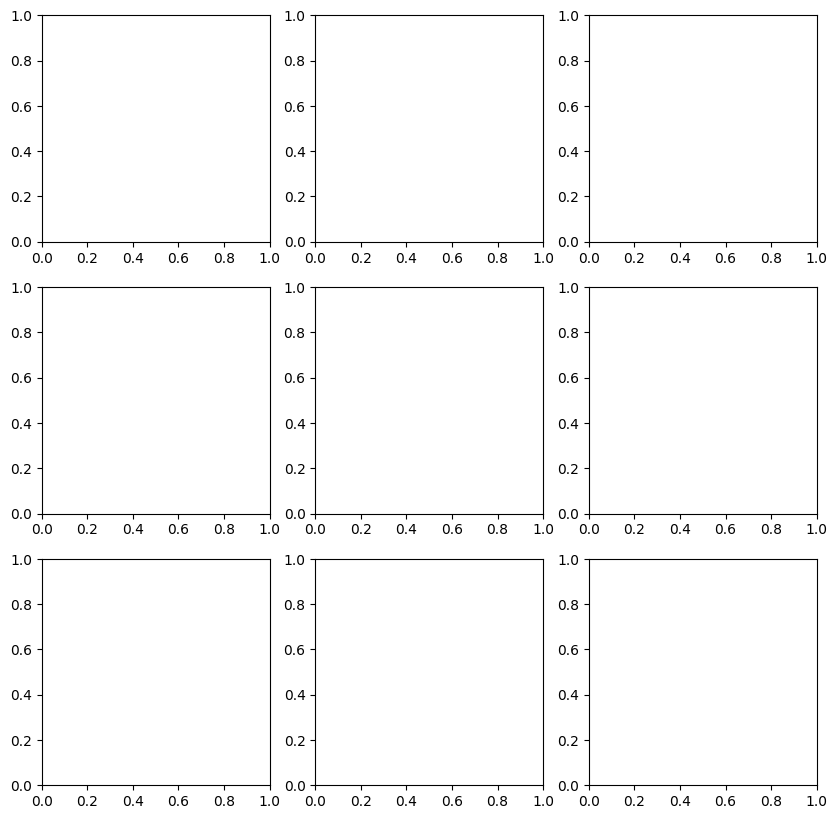

In [105]:
visualize_model(segment_model, segment_val_dataset, device, grid=(3,3), n_dims=2)